In [1]:
import pickle
import pandas as pd
import numpy as np
from spiker import *
import matplotlib.pyplot as plt
from rnn import rnn

In [2]:
# https://www.mathworks.com/help/ident/ref/goodnessoffit.html
def goodness_of_fit(ann_states, snn_states):
    nmse_layers = []
    epsilon = 1e-14
    layers = range(len(ann_states))
    transient = 10000
    for idx in layers: # layer idx
        dims = ann_states[idx].shape[0]
        nmse = []
        for jdx in range(dims):
            ref = ann_states[idx][jdx,transient:]
            y = snn_states[idx][jdx,transient:]
            diff = ref - y
            num = np.sum(diff*diff)
            ref_ch_mean = np.mean(ref)
            ref_diff = ref - ref_ch_mean #+ epsilon
            den = np.sum(ref_diff*ref_diff)
            if (den < epsilon) | (num < epsilon):
                if num < den:
                    nmse += [1]
            else:
                nmse += [1 - (num/den)]
        nmse_layer = np.mean(nmse)
        print(f'MSE in layer {idx} is {nmse_layer:.3f}')
        nmse_layers += [nmse_layer]
    return nmse_layers
# goodness_of_fit(ann_states, snn_states)

In [38]:
def plot_activations(net, ann_states, rnn_states, label=''):
    plt.rcParams['lines.linewidth'] = 1.2
    import matplotlib.patches as mpatches
    # Plotting and visualization
    print('Pole frequency = {0:.3f} Hz'.format(1/net.tau))
    goodness = goodness_of_fit(ann_states, snn_states)
    for idx in range(len(ann_states)): # layer idx
        dims = ann_states[idx].shape[0]
        if dims >= 3:
            cols = 3
        else:
            cols=dims
        rows = int(np.ceil(dims/cols))
        fig, axs = plt.subplots(rows,cols)
        for jdx in range(ann_states[idx].shape[0]): # dim idx
            ax = plt.subplot(rows,cols,jdx+1)
            plt.plot(tsteps, ann_states[idx][jdx,:], color='r', linestyle='-.', label=f'ANN - Layer {idx}')
            plt.plot(tsteps, snn_states[idx][jdx,:], color='g', alpha=0.7, label=f'SNN - Layer {idx}')
            plt.axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            
        label_ext = r' Mismatch $\sigma = $'+f'{mismatch}.'+f' NMSE = {goodness[idx]:.3f}.'
            
        if idx == 0:
            fig.suptitle(f'Input feed-forward layer.'+label_ext, fontsize=12)
        elif idx == len(ann_states)-1:
            fig.suptitle(f'Output feed-forward layer.'+label_ext, fontsize=12)
        elif idx%2 == 1:
            fig.suptitle(f'Recurrent layer {int(np.floor((idx+1)/2))}.'+label_ext, fontsize=12)
        else:
            fig.suptitle(f'Feed-forward layer {int(np.floor((idx)/2))}.'+label_ext, fontsize=12)
        patch1 = mpatches.Patch(color='g', label='ANN output')
        patch2 = mpatches.Patch(color='r', label='SNN output')
        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        fig.legend(handles=[patch1, patch2], loc='lower center', fancybox=True, shadow=True, fontsize=12, ncol=2)
        plt.savefig(f'./img/ANN-RNN-Layer-{idx}-{label}.png', dpi=300)
    t = 0
    for N in net.neurons:
        t += np.sum(N.spike_count)
    print('Average spike rate = {0:.3f} KHz'. format(1e-3*t/(tsteps[-1]*op_dim+res_dim+ip_dim)))

Sequence length is 200000


(2, 200000)

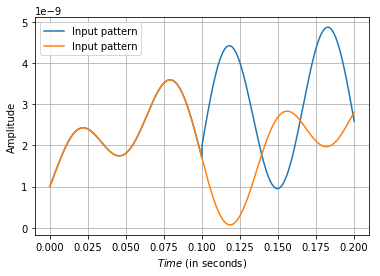

In [4]:
# Generate simulation data
def gen_data(nblocks,f1,f2, tstart=0, tstop=0.0001, Ts=1e-6,amp=1e-9):
    """
    Generates a time series comprising nblocks of data
    Each block is some combination of two sinusoids.
    nblocks = number of blocks
    tseries = Tseries object. Tseries is a datastructure 
        that makes it easy to deal with time-series data
    amp = Scales the entire data block
    """
    #np.random.seed(1)
    tseries = gen_time(tstart,tstop,Ts) # obtain the time series input sample
    time = tseries.time
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+1*np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
        else:
            block = 1*np.sin(2*np.pi*timeblock*f2)+2*np.sin(2*np.pi*timeblock*f1)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
    return amp*ip, amp*op, time
# Some input
ip1,_,tsteps = gen_data(nblocks=2, f1=4, f2=15, tstop=0.2)
ip2,_,tsteps = gen_data(nblocks=1, f1=4, f2=15, tstop=0.2)

inp1 = Tseries(ip1, tsteps)
inp2 = Tseries(ip2, tsteps)
inp1.plot(label = "Input pattern")
inp2.plot(label = "Input pattern")
ip = np.stack((ip1,ip2))
print('Sequence length is {}'.format(ip.shape[1]))
ip.shape# = (1,ip.shape[0])

In [5]:
def run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams):
    net = rnn(nrlayers, ip_dim, res_dim, op_dim, nparams=nparams)
    ann_states = net.rnn_forward(ip, mode='ann')
    snn_states = net.rnn_forward(ip, mode='snn')
    return ann_states, snn_states, net

In [6]:
# Test case to study effect of mismatch
ip_dim = ip.shape[0]
op_dim = 3
res_dim = 51
nrlayers = 4
seq_len = ip.shape[1]
nparams = {}
nmse_avgs = {}
nmse_stds = {}
nruns = 20
mismatch_list = [0, 0.2, 1, 1.5, 2]
# mismatch_list = [0, 2]
for mismatch in mismatch_list:
    print('='*89)
    print(f'Running {nruns} tests with mismatch std = {mismatch}')
    nmse_runs = []
    for _ in range(nruns):
        print(f'Test #{_+1}/{nruns}'+'-'*10)
        nparams['mismatch'] = mismatch
        ann_states, snn_states,_ = run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams)
        nmse_runs += [goodness_of_fit(ann_states, snn_states)]
    nmse_runs = np.array(nmse_runs)
    nmse_avgs[r'$\sigma$ '+f' = {mismatch}'] = np.mean(nmse_runs, axis=0)
    nmse_stds[r'$\sigma$ '+f' = {mismatch}']  = np.std(nmse_runs, axis=0)
#     plt.semilogy(range(len(ann_states)), nmse_avgs[mismatch], label = f'Mismatch std = {mismatch}')
nmse_avgs = pd.DataFrame.from_dict(nmse_avgs)
nmse_stds = pd.DataFrame.from_dict(nmse_stds) 
results = (nmse_avgs, nmse_stds)
with open('./img/mapping_mismatch.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Running 20 tests with mismatch std = 0
Test #1/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.998
MSE in layer 2 is 0.994
MSE in layer 3 is 0.984
MSE in layer 4 is 0.979
MSE in layer 5 is 0.967
MSE in layer 6 is 0.959
MSE in layer 7 is 0.927
MSE in layer 8 is 0.949
Test #2/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 1.000
MSE in layer 3 is 1.000
MSE in layer 4 is 0.996
MSE in layer 5 is 0.995
MSE in layer 6 is 0.990
MSE in layer 7 is 0.987
MSE in layer 8 is 0.986
Test #3/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.999
MSE in layer 2 is 0.993
MSE in layer 3 is 0.987
MSE in layer 4 is 0.984
MSE in layer 5 is 0.931
MSE in layer 6 is 0.947
MSE in layer 7 is 0.897
MSE in layer 8 is 0.915
Test #4/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.968
MSE in layer 2 is 0.959
MSE in layer 3 is 0.926
MSE in layer 4 is 0.943
MSE in layer 5 is 0.935
MSE in layer 6 is 0.913
MSE in layer 7 is 0.881
MSE in layer 8 is 0.939
Test #5/20---

MSE in layer 3 is 0.668
MSE in layer 4 is 0.481
MSE in layer 5 is -0.820
MSE in layer 6 is -1.198
MSE in layer 7 is 0.327
MSE in layer 8 is -0.255
Test #15/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.999
MSE in layer 2 is 0.995
MSE in layer 3 is 0.987
MSE in layer 4 is 0.976
MSE in layer 5 is 0.772
MSE in layer 6 is 0.647
MSE in layer 7 is -0.608
MSE in layer 8 is 0.352
Test #16/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 1.000
MSE in layer 3 is 0.981
MSE in layer 4 is 0.967
MSE in layer 5 is 0.821
MSE in layer 6 is 0.845
MSE in layer 7 is 0.538
MSE in layer 8 is 0.722
Test #17/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 1.000
MSE in layer 3 is 0.987
MSE in layer 4 is 0.973
MSE in layer 5 is 0.968
MSE in layer 6 is 0.936
MSE in layer 7 is 0.049
MSE in layer 8 is 0.776
Test #18/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.939
MSE in layer 2 is 0.910
MSE in layer 3 is 0.872
MSE in layer 4 is 0.

MSE in layer 2 is 1.000
MSE in layer 3 is 1.000
MSE in layer 4 is 1.000
MSE in layer 5 is 1.000
MSE in layer 6 is 0.996
MSE in layer 7 is -0.058
MSE in layer 8 is -0.004
Test #8/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 0.999
MSE in layer 3 is 0.998
MSE in layer 4 is 0.995
MSE in layer 5 is 0.987
MSE in layer 6 is 0.977
MSE in layer 7 is -3.388
MSE in layer 8 is -0.999
Test #9/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.999
MSE in layer 2 is 0.996
MSE in layer 3 is 0.967
MSE in layer 4 is 0.949
MSE in layer 5 is 0.882
MSE in layer 6 is 0.874
MSE in layer 7 is -3.509
MSE in layer 8 is -0.120
Test #10/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 1.000
MSE in layer 3 is 0.997
MSE in layer 4 is 0.988
MSE in layer 5 is -0.107
MSE in layer 6 is -0.900
MSE in layer 7 is -18.053
MSE in layer 8 is -4.894
Test #11/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 1.000
MSE in layer 3 

MSE in layer 2 is -8.944
MSE in layer 3 is -52.365
MSE in layer 4 is -117.056
MSE in layer 5 is -31.966
MSE in layer 6 is -34.815
MSE in layer 7 is -128.509
MSE in layer 8 is -107.846


In [7]:
with open('./img/mapping_mismatch.pickle', 'rb') as handle:
    nmse_avgs, nmse_stds = pickle.load(handle)

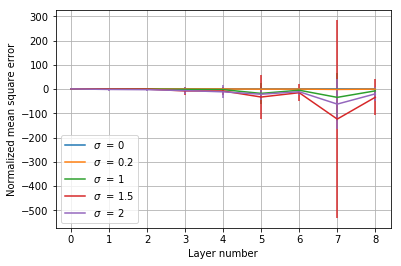

In [8]:
label = []
for idx in range(2*nrlayers+1):
    if idx == 0:
        label += [f'Input feed-forward layer']
    elif idx == len(ann_states)-1:
        label += [f'Output feed-forward layer']
    elif idx%2 == 1:
        label += [f'Recurrent layer {int(np.floor((idx+1)/2))}']
    else:
        label += [f'Feed-forward layer {int(np.floor((idx)/2))}']
nmse_stds['Layer'] = label
nmse_avgs['Layer'] = label

nmse_avgs.set_index('Layer')
nmse_stds.set_index('Layer')
ax = nmse_avgs.plot(yerr = nmse_stds, style='o')

plt.xlabel('Layer number')
plt.ylabel('Normalized mean square error')
plt.grid(True)
plt.savefig('./img/mismatch_rnn.pdf', dpi=300)

In [17]:
df_keys = pd.concat([nmse_stds,nmse_avgs], keys=['Std', 'Mean'])
df = df_keys.T.reorder_levels([1,0], axis=1)
names = df.columns.values
new_idx = np.zeros(len(names))
new_order = np.array([])
idx = 0
for n in names:
    if n[1] == 'Mean':
        new_idx[n[0]*2] = idx
    else:
        new_idx[n[0]*2 + 1] = idx
    idx += 1
new_idx = new_idx.astype(int)
new_order = names[new_idx]
df_reorder = df[new_order]
indices = df_reorder.T.index.values.tolist()
layer_names = df.T['Layer'].values

new_names = []
for index in indices:
    new_names += [(layer_names[index[0]], index[1])]
df_reorder.columns = pd.MultiIndex.from_tuples(new_names)
df_final = df_reorder.T.drop('Layer', axis=1)
df_final
# df = df.rename(columns = {"Col_1":"Mod_col"})

$\sigma$  = 0 $\sigma$  = 0.2 $\sigma$  = 1  \
Input feed-forward layer  Mean             1               1             1   
                          Std              0               0             0   
Recurrent layer 1         Mean      0.962989        0.973521       0.33506   
                          Std       0.149136       0.0612002       1.98282   
Feed-forward layer 1      Mean      0.959719        0.968604     0.0274758   
                          Std       0.151253       0.0576381       2.45971   
Recurrent layer 2         Mean      0.918909        0.732415      -1.19214   
                          Std       0.189444        0.341506       3.54579   
Feed-forward layer 2      Mean      0.921745        0.656983       -2.0619   
                          Std       0.197507        0.440619       4.62926   
Recurrent layer 3         Mean      0.847539      -0.0606124      -17.4977   
                          Std       0.368276         1.54544       42.5819   
Feed-forward layer 3      Mean      0.884175        0.222203      -4.52404   
                          Std        0.23553        0.838123       5.70458   
Recurrent layer 4         Mean      0.865608        -1.33335        -33.93   
                          Std       0.218588         4.50359       98.7681   
Output feed-forward layer Mean      0.868284       0.0729728      -7.09152   
                          Std       0.223157        0.998065        7.5061   

                               $\sigma$  = 1.5 $\sigma$  = 2  
Input feed-forward layer  Mean               1             1  
                          Std                0             0  
Recurrent layer 1         Mean        0.416623      -1.28823  
                          Std          2.06903       7.39495  
Feed-forward layer 1      Mean       0.0505507      -2.17091  
                          Std          3.14271       7.08492  
Recurrent layer 2         Mean         -7.4339      -5.87696  
                          Std          15.5052       13.0847  
Feed-forward layer 2      Mean        -7.54823      -11.1484  
                          Std          15.3315        26.834  
Recurrent layer 3         Mean        -32.5501      -20.9642  
                          Std          89.1349       25.6416  
Feed-forward layer 3      Mean         -14.727      -10.6933  
                          Std          34.8797       12.1326  
Recurrent layer 4         Mean        -123.486      -61.6727  
                          Std          407.618       102.048  
Output feed-forward layer Mean        -33.4382      -19.4922  
                          Std          75.1131       28.0848

In [19]:
with open('./img/mismatch_sims.tex', 'w') as tf:
     tf.write(df_final.to_latex(escape=False))

Pole frequency = 676.930 Hz
MSE in layer 0 is 1.000
MSE in layer 1 is 0.999
MSE in layer 2 is 0.996
MSE in layer 3 is 0.983
MSE in layer 4 is 0.970
MSE in layer 5 is 0.951
MSE in layer 6 is 0.910
MSE in layer 7 is 0.889
MSE in layer 8 is 0.860
Average spike rate = 160.570 KHz


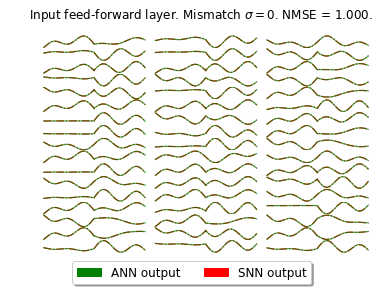

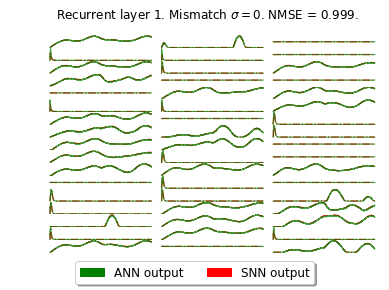

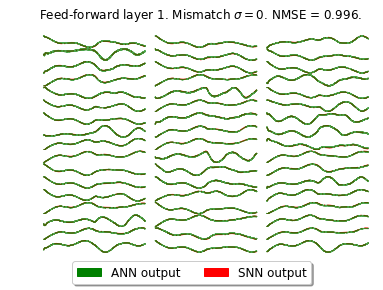

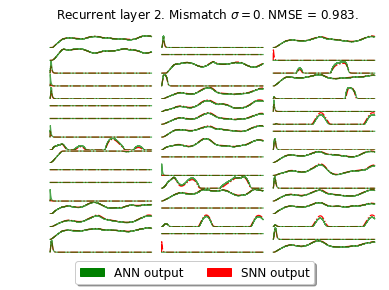

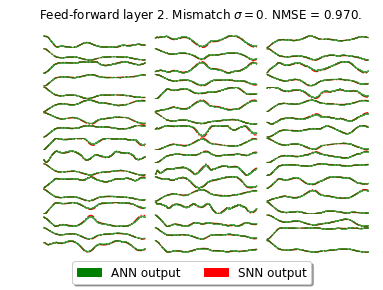

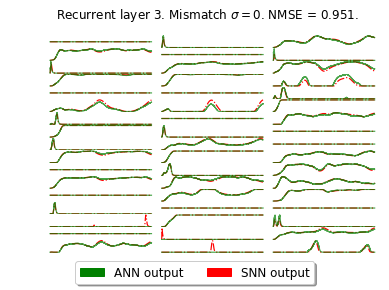

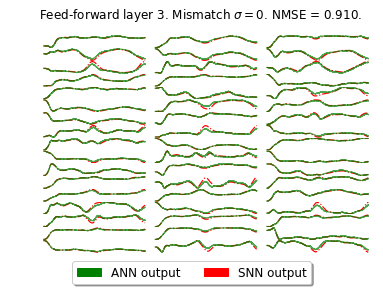

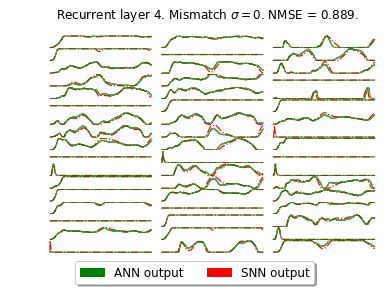

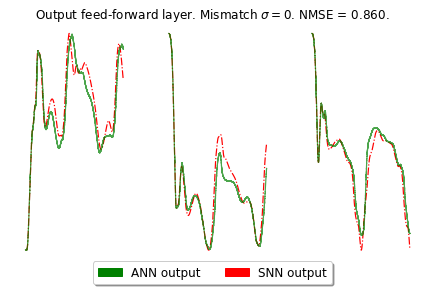

In [39]:
# Test case for plotting dynamics
mismatch = 0
nparams['mismatch'] = mismatch
ann_states, snn_states, net = run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams)
plot_activations(net, ann_states, snn_states, label=f'mismatch std={mismatch}')

Pole frequency = 676.930 Hz
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 1.000
MSE in layer 3 is 0.790
MSE in layer 4 is 0.646
MSE in layer 5 is -5.289
MSE in layer 6 is -5.430
MSE in layer 7 is -27.986
MSE in layer 8 is -1.289
Average spike rate = 127.386 KHz


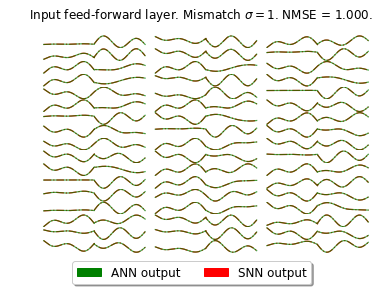

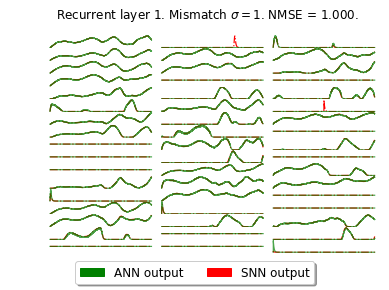

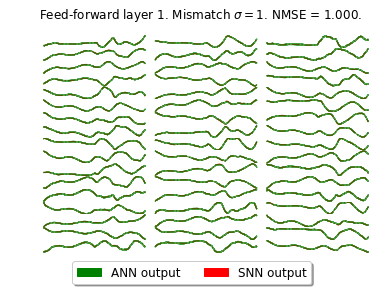

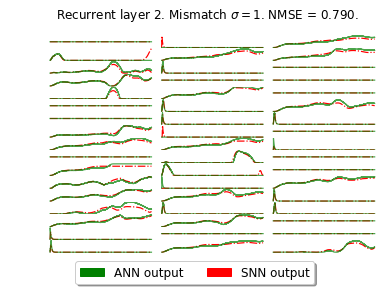

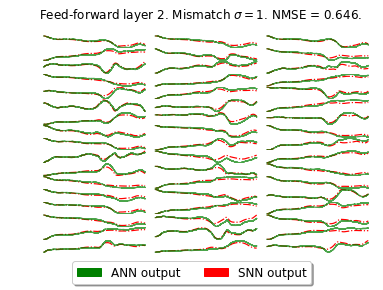

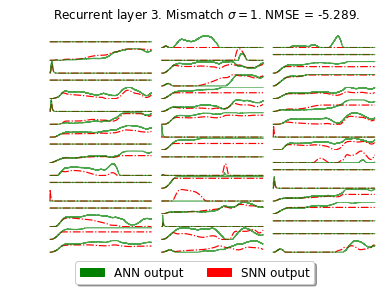

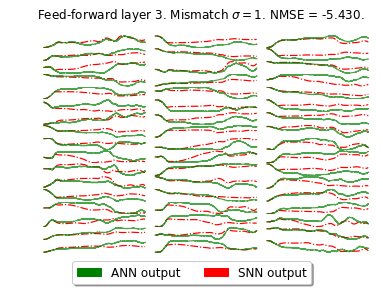

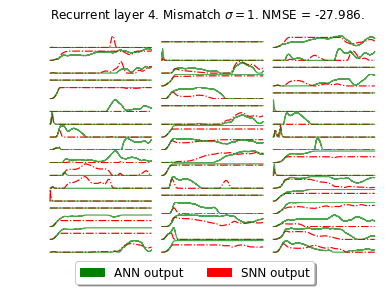

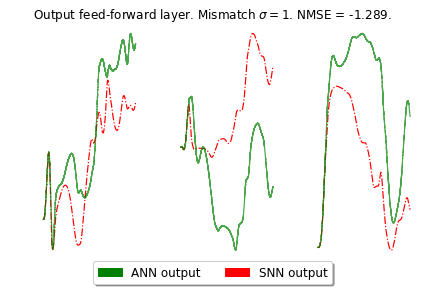

In [40]:
# Test case for plotting dynamics
mismatch = 1
nparams['mismatch'] = mismatch
ann_states, snn_states, net = run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams)
plot_activations(net, ann_states, snn_states, label=f'mismatch std={mismatch}')